In [34]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image 

In [35]:
def conv(imag,filt,stride,pad):

    cnv_1 = ((imag.shape[0] + 2*pad) - filt.shape[0])//stride + 1
    cnv_2 = ((imag.shape[1] + 2*pad) - filt.shape[1])//stride + 1
    
    b = np.zeros((filt.shape[0]*filt.shape[1],cnv_1*cnv_2),dtype="float64")
    
    z=0
    
    for i in range(cnv_1):
        v_start = i * stride
        v_end = v_start + filt.shape[0]
        for j in range(cnv_2):

            
            h_start = j * stride
            h_end = h_start + filt.shape[1]
            
            b[:,z] = imag[v_start:v_end,h_start:h_end].flatten()
            
            z+=1
    b=np.dot(np.reshape(filt,(filt.shape[0]*filt.shape[1],1)).T,b)
    
    return np.reshape(b,(cnv_1,cnv_2)) 



def max_pool(imag,stride,filt):
    
    cnv_1 = (imag.shape[0] - filt[0])//stride + 1
    cnv_2 = (imag.shape[1] - filt[1])//stride + 1
    
    pool = np.zeros((filt[0]*filt[1],cnv_1*cnv_2),dtype="float64")
    
    z=0
    for i in range(cnv_1):
        for j in range(cnv_2):
            v_start = i * stride
            v_end = v_start + filt[0]
            
            h_start = j * stride
            h_end = h_start + filt[1]
            
            pool[:,z] = imag[v_start:v_end,h_start:h_end].flatten()
            #print(imag[v_start:v_end,h_start:h_end].flatten())
            z+=1
    pool = np.max(pool,axis=0,keepdims=True)
    #print(pool.shape)
    return np.reshape(pool,(cnv_1,cnv_2))


def D_max_pool(imag,stride,filt,d):
    
    cnv_1 = (imag.shape[0] - filt[0])//stride + 1
    cnv_2 = (imag.shape[1] - filt[1])//stride + 1
    
    #pool = np.zeros((filt[0]*filt[1],cnv_1*cnv_2),dtype="float32")
    der = np.zeros((imag.shape[0],imag.shape[1]),dtype="float64")
    z=0
    for i in range(cnv_1):
        
        v_start = i * stride
        v_end = v_start + filt[0]
        for j in range(cnv_2):
            

            h_start = j * stride
            h_end = h_start + filt[1]
            a=imag[v_start:v_end,h_start:h_end]

            der[v_start:v_end,h_start:h_end][np.argmax(a)//a.shape[1],np.argmax(a)%a.shape[0]] = d[i,j]
        
    return der

def back_pool(a,b):
    return np.isin(a,b,assume_unique=True)*a

In [36]:
def relu(mat):
    return(np.multiply(mat,np.where(mat>=0,1,0)))

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(A):
    da = sigmoid(A)
    return da*(1-da)
def relu_backward(A):
    return np.where(A>=0,1,0)



In [4]:
def gradient_descent(parameters,grads,learning_rate):
    L = len(parameters) 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate*grads["dW"+str(l+1)])
        #parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate*grads["db"+str(l+1)])
    return parameters

In [5]:
def init_adam_prm(parameters):
    v,s= {},{}
    L = len(parameters)#//2
    for i in range(L):
        v["dW" + str(i+1)] = np.zeros(parameters["W" + str(i+1)].shape)
        #v["db" + str(i+1)] = np.zeros(parameters["b" + str(i+1)].shape)
        s["dW" + str(i+1)] = np.zeros(parameters["W" + str(i+1)].shape)
        #s["db" + str(i+1)] = np.zeros(parameters["b" + str(i+1)].shape)
        
    return v,s

In [6]:
def adam_optimizer(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):

    v_corrected,s_corrected={},{}
    L = len(parameters)#//2
    for i in range(L):
        v["dW" + str(i+1)] = beta1 * v["dW" + str(i+1)] + (1-beta1)*grads["dW" + str(i+1)]
        #v["db" + str(i+1)] = beta1 * v["db" + str(i+1)] + (1-beta1)*grads["db" + str(i+1)]
        
        v_corrected["dW" + str(i+1)] = v["dW" + str(i+1)]/(1-(beta1**t))
        #v_corrected["db" + str(i+1)] = v["db" + str(i+1)]/(1-(beta1**t))
        
        s["dW" + str(i+1)] = beta2 * s["dW" + str(i+1)] + (1-beta2)*(grads["dW" + str(i+1)]**2)
        #s["db" + str(i+1)] = beta2 * s["db" + str(i+1)] + (1-beta2)*(grads["db" + str(i+1)]**2)
        
        s_corrected["dW" + str(i+1)] = s["dW" + str(i+1)]/(1-(beta2**t))
        #s_corrected["db" + str(i+1)] = s["db" + str(i+1)]/(1-(beta2**t))
        
        parameters["W" + str(i+1)] =parameters["W" + str(i+1)] - (learning_rate*(v_corrected["dW" + str(i+1)]/(np.sqrt(s_corrected["dW" + str(i+1)])+epsilon)))
       # parameters["b" + str(i+1)] =parameters["b" + str(i+1)] - (learning_rate*(v_corrected["db" + str(i+1)]/(np.sqrt(s_corrected["db" + str(i+1)])+epsilon)))
    
                                                                  
    return parameters,v,s

In [7]:
def compute_cost(AL,Y):

    m =Y.shape[1]
    
    cost = np.sum(np.multiply(Y,np.log(AL)),axis=1,keepdims=True) + np.sum(np.multiply(1-Y,np.log(1-AL)),axis=1,keepdims=True)
    cost=np.sum(cost)
    #cost = cost/-m  
    
    cost = np.squeeze(cost) #(will turn [[13]] -> 13)
    
    assert(cost.shape == ())
    return cost

In [50]:
import random
def data(path):

    os.chdir(path)
    #os.chdir("cats")
    aa=["cats","dogs"]
    training_data=[]

    #print(X)
    for a in aa:
        path = os.path.join(os.getcwd(),a)
        ind = aa.index(a) #+ 1
        print(path)
        for img in os.listdir(path):
            try:

                image  = Image.open(os.path.join(path,img))
                image = image.convert("L")
                image =image.resize((250,250))
                
                image = np.array(image,ndmin=2)
                image = image/255
                training_data.append([image,np.array(ind,ndmin=2)])
            except IOError:
                pass
    
    #random.shuffle(training_data)
 

          
    return training_data

In [9]:
def fwd(img):
        Z1 = conv(img,W1,1,0)
        A1 = relu(Z1)
        P1 = max_pool(A1,2,(3,3))
        Z2 = conv(P1,W2,1,0)
        A2 = relu(Z2)
        P2 = max_pool(A2,2,(3,3))
        f_c = np.reshape(P2,(P2.shape[0]*P2.shape[1],1))
        Z3 = np.dot(W3,f_c)
        A3 = sigmoid(Z3)
        return A3

In [10]:
def prediction(pics):
    s=0
    
    m =len(pics)
    for p in pics:
        
        
        y=fwd(p[0])
        
       
        if y>0.5:
            y=1
        else:
            y=0
        
        
        
        s+=np.squeeze(np.where(y==p[1],1,0))
        
    print(s)
        #break 

    print("prediction accuracy" + " " + str(s/m))
    
    

In [443]:
prediction(pics)

66
prediction accuracy 0.5454545454545454


In [51]:
#os.chdir("../../../")

print(os.getcwd())


pics = data(os.getcwd() )
print("done")

C:\Users\LAPY\Desktop
C:\Users\LAPY\Desktop\cats
C:\Users\LAPY\Desktop\dogs
done


In [12]:
print(len(pics))

28


In [69]:
parameters = {}
parameters["W1"] = np.ones((3,3))*0.0054#np.sqrt(1/(250))
parameters["W2"] = np.ones((3,3))*0.0054#np.sqrt(1/(200))
parameters["W3"] = np.ones((1,60516))*0.0054#np.sqrt(1/(200))
pm = parameters["W1"]
cm=parameters["W2"]
print(parameters["W1"])

[[0.0054 0.0054 0.0054]
 [0.0054 0.0054 0.0054]
 [0.0054 0.0054 0.0054]]


In [70]:
costs = []
grads={}
t=0
W1 = parameters["W1"]
W2 = parameters["W2"]
W3 = parameters["W3"]

v,s = init_adam_prm(parameters)

for i in range(3001):
    try:
        cost = 0
        dW1,dW2,dW3 = np.zeros(W1.shape),np.zeros(W2.shape),np.zeros(W3.shape)
        #np.random.shuffle(pics)
        for img in pics:
            Z1 = conv(img[0],W1,1,0)
            A1 = relu(Z1)
            #P1 = max_pool(A1,2,(3,3))
            Z2 = conv(A1,W2,1,0)
            A2 = relu(Z2)
            #P2 = max_pool(A2,2,(3,3))
            f_c = np.reshape(A2,(A2.shape[0]*A2.shape[1],1))
            Z3 = np.dot(W3,f_c)
            A3 = sigmoid(Z3)
            cost+= np.squeeze(np.sum(np.multiply(img[1],np.log(A3)),axis=1,keepdims=True) + np.sum(np.multiply(1-img[1],np.log(1-A3)),axis=1,keepdims=True))

            dZ3 = A3 - img[1]
            dW3 += np.dot(dZ3,f_c.T)
            dF_c = np.dot(W3.T,dZ3)
            dA2 = np.reshape(dF_c,(A2.shape[0],A2.shape[1]))
            
            #dA2 = D_max_pool(A2,2,(3,3),dF_c)

            dZ2 = np.multiply(dA2,relu_backward(Z2))
            

            dW2 += conv(A1,dZ2,1,0)
            

            dA1 = (conv(np.pad(dZ2,(W2.shape[0]-1,W2.shape[1]-1),"constant"),np.rot90(W2,2),1,0))
            
            #dA1 = D_max_pool(A1,2,(3,3),dP1)

            dZ1 = np.multiply(dA1,relu_backward(Z1))
            
            
            dW1+= conv(img[0],dZ1,1,0)
        print(dW1)
        break
        grads["dW1"] = dW1/len(pics)
        grads["dW2"] = dW2/len(pics)
        grads["dW3"] = dW3/len(pics)
        t+=1
        parameters,v,s = adam_optimizer(parameters,grads,v,s,t,learning_rate=0.0008)
        W1 = parameters["W1"]
        W2 = parameters["W2"]#/len(pics)
        #print(W2)
        W3 = parameters["W3"]#/len(pics)

        costs.append(cost/-len(pics))
        if i %1 == 0:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost/-len(pics))))
    except KeyboardInterrupt:
        plt.plot(np.squeeze(costs))
        plt.show()
        br=True
        break
if(br == False):
    plt.plot(np.squeeze(costs))
    plt.show()



[[14.22404557 14.25339004 14.26058981]
 [14.23413159 14.26340916 14.27056524]
 [14.23404013 14.26320029 14.27029466]]


In [37]:
def ing(a):
    im = Image.open(a)
    im = im.resize((250,250))
    im = im.convert("L")
    #im.show()
    
    return np.array(im)
# def pred(img):
#         Z1 = conv(img,W1,1,0)
#         A1 = relu(Z1)
#         P1 = max_pool(A1,2,(3,3))
#         Z2 = conv(P1,W2,1,0)
#         A2 = relu(Z2)
#         P2 = max_pool(A2,2,(3,3))
#         f_c = np.reshape(P2,(P2.shape[0]*P2.shape[1],1))
#         Z3 = np.dot(W3,f_c)
#         A3 = sigmoid(Z3)
#         print(A3,Z3)

In [4]:
print(ing("cat9.jpg").shape)

(250, 250)


In [44]:
print(pm)
print(cm)
print(W1)
print(W2)

[[2.90111565e-06 5.27304123e-03 4.59369082e-04]
 [1.02799553e-03 8.26096202e-05 7.08350807e-04]
 [8.25300486e-03 2.12462835e-03 8.57304247e-04]]
[[0.00197901 0.00376443 0.00582343]
 [0.00809546 0.00638239 0.00431747]
 [0.00375578 0.0027444  0.00381227]]
[[0.02806653 0.03331204 0.02812111]
 [0.02934079 0.02834219 0.02855568]
 [0.03651226 0.03029613 0.02860218]]
[[0.02987413 0.03170746 0.03345402]
 [0.03619006 0.03448665 0.03205723]
 [0.03173322 0.03070617 0.0313991 ]]


In [33]:
# dZ3 = A3 - y
# dW3 = np.dot(dZ3,f_c.T)
# dF_c = np.dot(W3.T,dZ3)
# dF_c = np.reshape(dF_c,(P2.shape[0],P2.shape[1]))
# #print(dF_c.shape,P2.shape,f_c.shape)
# dA2 = D_max_pool(A2,2,(3,3),dF_c)
# dZ2 = np.multiply(dA2,relu_backward(Z2))
# dW2 = conv(P1,dZ2,1,0)
# dP1 = (conv(np.pad(dZ2,(W2.shape[0]-1,W2.shape[1]-1),"constant"),W2,1,0))
# #print(dW2.shape,W2.shape,P1.shape,dZ2.shape,im.shape,Z1.shape)
# #print(P1.shape,dP1.shape)
# dA1 = D_max_pool(A1,2,(3,3),dP1)
# #print(dA1.shape,A1.shape)
# dZ1 = np.multiply(dA1,relu_backward(Z1))
# #print(dZ1.shape,Z1.shape)
# dW1 = conv(im,dZ1,1,0)
# #print(dW1.shape,W1.shape)

In [45]:
w=np.array(
[[-8.22686575e-01, -1.03847296e+00, -7.99829273e-01],
  [ 1.84303960e-01,  3.19780696e+00,  2.95756310e-03],
  [-2.66020768e-01 , 5.52292357e-01, -1.86208802e-01]]

)
f = np.array(([[1,2,1],
 [2,4,2],
 [1,2,1]])).T

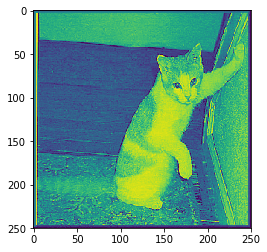

In [50]:
plt.imshow(ing("cat1.jpg")/255)

In [55]:
c=np.array(([1,1,1],[0,0,0],[-1,-1,-1])).T
#print(W1)
e = conv(ing("cat3.jpg")/255,w,1,0)


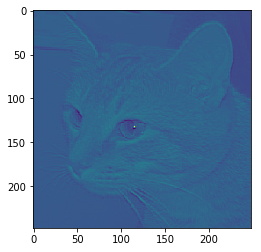

In [56]:
plt.imshow(e)

CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [174]:
print(e)

[[0.44288733 0.44509938 0.45602484 ... 0.44576721 0.44351774 0.43699362]
 [0.45407399 0.45720783 0.46096915 ... 0.45009869 0.44554105 0.43725168]
 [0.45580168 0.45981087 0.46070173 ... 0.45155483 0.44527752 0.43867669]
 ...
 [0.39050368 0.39768344 0.39485565 ... 0.36194036 0.35932962 0.35990155]
 [0.38964912 0.39541247 0.39284056 ... 0.35965676 0.35760025 0.35902902]
 [0.38678985 0.3925602  0.39140998 ... 0.35676318 0.35818083 0.35874083]]


In [175]:
print(im)

[[0.69019608 0.61568627 0.61960784 ... 0.67843137 0.66666667 0.6627451 ]
 [0.69019608 0.65882353 0.70196078 ... 0.68235294 0.6627451  0.63921569]
 [0.68627451 0.69019608 0.71372549 ... 0.68627451 0.66666667 0.63921569]
 ...
 [0.57647059 0.60392157 0.6        ... 0.54117647 0.54901961 0.54901961]
 [0.57254902 0.6        0.59607843 ... 0.54117647 0.54901961 0.54901961]
 [0.56862745 0.59215686 0.58823529 ... 0.5372549  0.54901961 0.54901961]]


In [104]:
print(fo)
print(fil)

[[1 1 0 1]
 [1 0 1 1]
 [0 1 1 1]
 [1 1 1 0]]
[[2 3]
 [3 3]]


In [105]:
print(fo*fil)

ValueError: operands could not be broadcast together with shapes (4,4) (2,2) 

In [155]:
#a=np.array(([1,2,-3,3],[3,4,9,-9],[0,3,2,1],[-1,2,6,7]))
a=np.random.randint(30,size=(5,5))
print(a)

[[24 21 19  0  5]
 [19 20 13 16 25]
 [21  2  8  4 27]
 [25  4 11 28  7]
 [13 29  8 12 14]]


In [156]:
print(relu(a))

[[24 21 19  0  5]
 [19 20 13 16 25]
 [21  2  8  4 27]
 [25  4 11 28  7]
 [13 29  8 12 14]]


In [165]:
f=max_pool(relu(a),1,(2,2))
print(f)

[[24. 21. 19. 25.]
 [21. 20. 16. 27.]
 [25. 11. 28. 28.]
 [29. 29. 28. 28.]]


In [196]:
print(D_max_pool(relu(a),1,(2,2),f))

[[ 24.  21.  19.   0.   0.]
 [  0.  20.   0.  16.  25.]
 [ 21.   0.   0.   0.  27.]
 [ 25.   0.  11. 112.   0.]
 [  0.  58.   0.   0.   0.]]
None


In [459]:
v=np.ones((3))

In [460]:
a=np.random.randint(50,size=(3,3))
print(a,"\n",np.argmax(a,axis=1,out=v))

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [435]:
print(a[6])

IndexError: index 6 is out of bounds for axis 0 with size 3

In [512]:
def back(imag,stride,filt):
    
    cnv_1 = (imag.shape[0] - filt[0])//stride + 1
    cnv_2 = (imag.shape[1] - filt[1])//stride + 1
    
    #pool = np.zeros((filt[0]*filt[1],cnv_1*cnv_2),dtype="float32")
    der = np.zeros((imag.shape[0],imag.shape[1]),dtype="float32")
    z=0
    for i in range(cnv_1):
        for j in range(cnv_2):
            v_start = i * stride
            v_end = v_start + filt[0]
            
            h_start = j * stride
            h_end = h_start + filt[1]
            a=imag[v_start:v_end,h_start:h_end]
            print(np.max(a),end=" ")
            #print(np.argmax(a)%a.shape[0],np.argmax(a)//a.shape[1],np.argmax(a),a[np.argmax(a)//a.shape[1],np.argmax(a)%a.shape[0]])
            der[v_start:v_end,h_start:h_end][np.argmax(a)//a.shape[1],np.argmax(a)%a.shape[0]] = 1
#             #print(imag[v_start:v_end,h_start:h_end].flatten())
#             #print(maxx, np.where(maxx == np.max(maxx),1,0))
#             m = maxx == np.max(maxx)
#             der[v_start:v_end,h_start:h_end] = m * d[i,j]
#             #print(i,j,z,v_start, v_end,h_start ,h_end)
#            # print(np.multiply(np.where(maxx == np.max(maxx),1,0),d[i,j]),"\n")
#             z+=1
    print("\n",der)
#     return der

In [519]:
a=np.random.randint(1000,size=(5,5))

In [520]:
print(a,"\n")
back(a,1,(3,3))

[[ 87 939 880  65 676]
 [472 634 448 545  57]
 [415 405 915 264 837]
 [806 625 395 557 670]
 [609 256 321  80 967]] 

939 939 915 915 915 915 915 915 967 
 [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
#                 
# Z1 = conv(im,W1,2,0)
# A1 = relu(Z1)
# P1 = max_pool(A1,1,W1)
# Z2 = conv(P1,W2,2,0)
# A2 = relu(Z2)
# P2 = max_pool(A2,1,W2)
# f_c = np.reshape(P2,(P2.shape[0]*P2.shape[1],1))
# Z3 = np.dot(W3,f_c)
# A3 = sigmoid(Z3)
# cost=compute_cost(A3,y)
# costs.append(cost)
# dZ3